In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress
from scipy.spatial.distance import cdist


from utils import geometry
from utils import fileio

In [2]:
input_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int/'
c_files=sorted(glob(input_dir+'20151125_1_GSV*_conf.csv'))
print(c_files)

micron_size=387.7
pixel_size=512

mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr*\\*\\Matrices'))

print(mat_dir)


R_all=[]
A_all=[]
B_all=[]
C_all=[]
cec_all=[]
cc_all=[]
nn_all=[]
col_names=[]
for i in range(len(c_files)):
    #print(f)

    #read in conf file
    edges_name,t_min, pixel_size, micron_size = fileio.read_conf(c_files[i])
    exp_id=edges_name.split('_')[0]+'_'+edges_name.split('_')[1]+'_'+edges_name.split('_')[4]+'_'+edges_name.split('_')[5]+'_'+edges_name.split('_')[7]
    t=t_min*60.0
    stretch_type=edges_name.split('_')[4][-1]
    stretch_len=edges_name.split('_')[5]
    frame=edges_name.split('_')[7][2:]
    print(exp_id)

    A  = np.loadtxt(glob(mat_dir[i]+'/*'+frame+'_*Matrix_A.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
    B  = np.loadtxt(glob(mat_dir[i]+'/*'+frame+'_*Matrix_B.txt')[0]) # Incidence matrix. Rows => cells; columns => edges. Values +/-1 for orientation
    C  = np.loadtxt(glob(mat_dir[i]+'/*'+frame+'_*Matrix_C.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
    R  = np.loadtxt(glob(mat_dir[i]+'/*'+frame+'_*Matrix_R.txt')[0])*(micron_size/pixel_size)
    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C,R,cec)
    nn=geometry.get_all_nn(B)

    A_all.append(A)
    B_all.append(B)
    C_all.append(C)
    R_all.append(R)
    cec_all.append(cec)
    cc_all.append(cc)
    nn_all.append(nn)
    col_names.append(exp_id.split('_')[-1])

['C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr001_trace_conf.csv', 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr016_trace_conf.csv', 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr031_trace_conf.csv', 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr046_trace_conf.csv', 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr061_trace_conf.csv', 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched\\20151125\\5min_int\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr076_trace_conf.csv', 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\un

In [3]:
track_all=[]
for j in range(1, len(cc_all)):
    track=[]
    for i in range(len(cc_all[j])):
        tr=np.where(cdist(cc_all[j], cc_all[j-1])[i]==np.min(cdist(cc_all[j], cc_all[j-1])[i]))[0][0]
        track.append(tr)
    track_all.append(track)

In [4]:
df=pd.DataFrame(np.transpose(np.vstack((np.array(track_all[0]),np.linspace(0, len(B_all[1])-1,len(B_all[1]) )))), columns=[col_names[0], col_names[1]], dtype=int)
for i in range(1,len(track_all)):
    dfright=pd.DataFrame(np.transpose(np.vstack((np.array(track_all[i]),np.linspace(0, len(B_all[i+1])-1,len(B_all[i+1]) )))), columns=[col_names[i], col_names[i+1]], dtype=int)
    df=pd.merge(df, dfright, on=col_names[i], how='right')

In [5]:
df_sorted=np.array(df.sort_values('fr001'))



In [6]:
np.unique(df_sorted[:,0])[np.where(np.unique(df_sorted[:,0], return_counts=True)[1]>1)]

array([ 46,  83,  86,  95,  98, 107, 134, 149, 153, 161, 168, 190, 194,
       198, 199, 208, 209])

178 is picked up incorrectly should go into 195
98 should divide into 189, 30

In [7]:
print(cc_all[11][185])
print(cc_all[11][25])

print(cc_all[11][185]-cc_all[12][29])
print(cc_all[11][25]-cc_all[12][29])
print(np.sqrt((cc_all[11][185]-cc_all[12][29])[0]**2+(cc_all[11][185]-cc_all[12][29])[1]**2))
print(np.sqrt((cc_all[11][25]-cc_all[12][29])[0]**2+(cc_all[11][25]-cc_all[12][29])[1]**2))

[283.52726004 193.63364955]
[300.92183594 185.97484375]
[-13.00266183  -6.12271763]
[  4.39191406 -13.78152344]
14.372087040490912
14.464414865135257


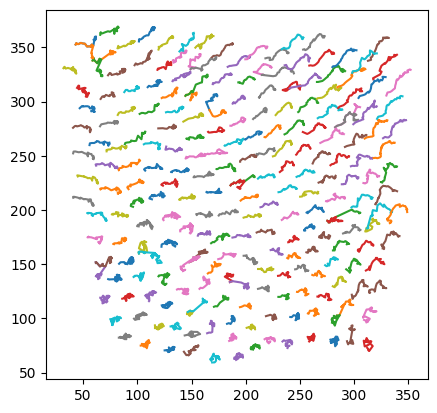

In [8]:
for i in range(len(df_sorted)):
        cc_tr=[]
        for j in range(len(cc_all)):
                cc_tr.append(cc_all[j][df_sorted[i][j]])
        cc_tr=np.array(cc_tr)
        plt.plot(cc_tr[:,0], cc_tr[:,1])
plt.gca().set_aspect('equal')
plt.savefig(input_dir+'/cc_tracks.png', dpi=300)


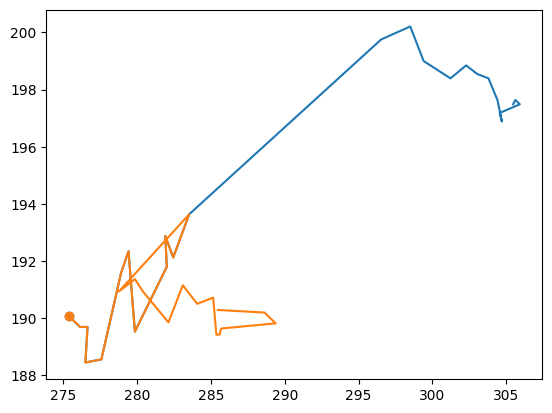

In [9]:
cc_tr=[]
for j in range(len(cc_all)):
        cc_tr.append(cc_all[j][df_sorted[102][j]])

cc_tr=np.array(cc_tr)
plt.plot(cc_tr[:,0], cc_tr[:,1])
plt.scatter(cc_tr[0,0], cc_tr[0,1])
cc_tr=[]
for j in range(len(cc_all)):
        cc_tr.append(cc_all[j][df_sorted[103][j]])

cc_tr=np.array(cc_tr)
plt.plot(cc_tr[:,0], cc_tr[:,1])
plt.scatter(cc_tr[0,0], cc_tr[0,1])

In [194]:
nodiv_cells=np.unique(df_sorted[:,0])[np.where(np.unique(df_sorted[:,0], return_counts=True)[1]==1)]
div_cells=np.unique(df_sorted[:,0])[np.where(np.unique(df_sorted[:,0], return_counts=True)[1]>1)]
d_cells=df_sorted[[x in div_cells for x in df_sorted[:,0]]]
nd_cells=df_sorted[[x in nodiv_cells for x in df_sorted[:,0]]]

In [195]:
data_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr*\\*\\Data'))

#files_i=sorted(glob(data_dir+'20210527_1_uf__fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
files_s=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_fr*\\*\\Data/20151125_*fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
df_dat=pd.read_csv(files_s[0])
df_dat['frame']=1
df_dat['time']=0
df_dat['angle_horizontal']=abs(np.where(df_dat[df_dat.time==0].major_shape_axis_alignment_rads<np.pi/2,df_dat[df_dat.time==0].major_shape_axis_alignment_rads, df_dat[df_dat.time==0].major_shape_axis_alignment_rads-np.pi))
i=1
for f in files_s[1:]:
    data_s=pd.read_csv(f)
    data_s['frame']=int(f.split('\\')[-1].split('_')[2][2:])
    data_s['time']=(i+4)*60
    data_s['angle_horizontal']=abs(np.where(data_s.major_shape_axis_alignment_rads<np.pi/2,data_s.major_shape_axis_alignment_rads, data_s.major_shape_axis_alignment_rads-np.pi))
    df_dat=pd.concat([df_dat, data_s], ignore_index=True)
    i+=5

In [10]:
df_dat.columns

Index(['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'cell_perimeter_nd', 'cell_area_nd', 'cell_P_eff_nd', 'shape_parameter',
       'circularity', 'cell_edge_count', 'cell_shear', 'cell_zeta',
       'major_shape_axis_alignment_rads', 'major_stress_axis_alignment_rads',
       'frame', 'time', 'angle_horizontal'],
      dtype='object')

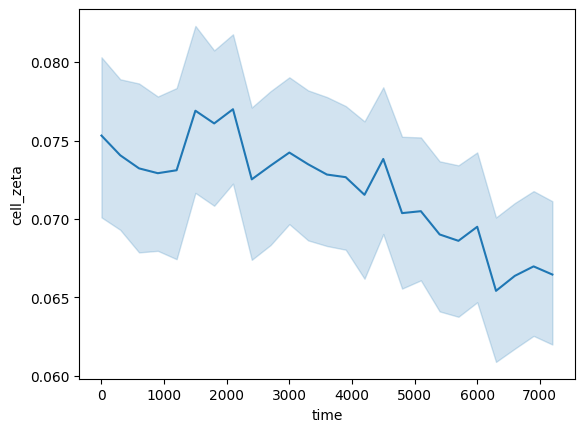

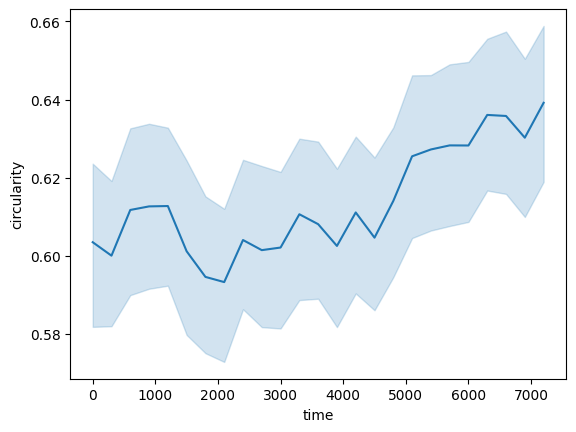

<AxesSubplot: xlabel='time', ylabel='shape_parameter'>

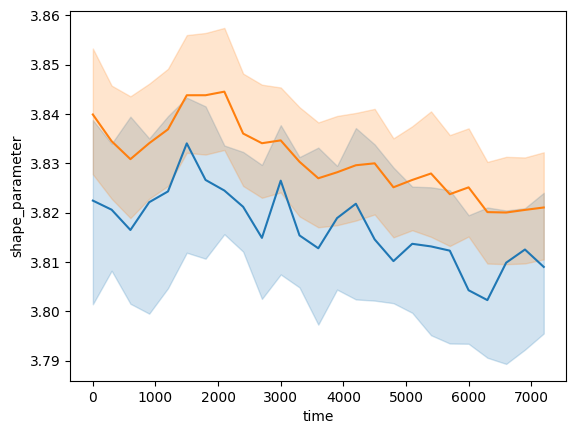

In [180]:


sns.lineplot(data=df_dat, y='cell_zeta', x='time')
plt.show()
sns.lineplot(data=df_dat, y='circularity', x='time')
plt.show()
sns.lineplot(data=df_dat, y='shape_parameter', x='time', estimator=np.median)
sns.lineplot(data=df_dat, y='shape_parameter', x='time', estimator=np.mean)

In [12]:
time=np.unique(df_dat.time)

In [196]:

nd_data=np.zeros((len(time)*len(nd_cells), len(df_dat.iloc[0])))
for j in range(len(nd_cells)):
    for i in range(len(time)):
        n=j*len(time)+i
        c=np.array(df_dat[ (df_dat.cell_id==nd_cells[j, i])&(df_dat.time==time[i])])[0]
        
        c[0]=nd_cells[j,0]
        nd_data[n, :]=c

In [234]:
print(len(np.unique(d_cells[:,0])))
print(len(d_cells))
np.min(np.where(d_cells[0]!=d_cells[1]))
[np.min(np.where(d_cells[x]!=d_cells[x+1])) for x in np.linspace(0, len(d_cells)-2, len(np.unique(d_cells[:,0]))).astype(int)]
df_dat[ (df_dat.cell_id==d_cells[1, 16])&(df_dat.time==time[16])]
#np.max(df_dat[df_dat.time==0].cell_id)

#print(np.unique(d_cells[:,0]))
#np.max([np.max(nd_cells[:,0]),np.max(d_cells[:,0])])
d_cells[16,16]

17
34


162

In [198]:
Nc=np.max([np.max(nd_cells[:,0]),np.max(d_cells[:,0])])+1
cells=[]
for j in np.linspace(0, len(d_cells)-2, len(np.unique(d_cells[:,0]))).astype(int):
    div_time=np.min(np.where(d_cells[j]!=d_cells[j+1]))
    print(j)

    for i in range(div_time):
        c=np.array(df_dat[ (df_dat.cell_id==d_cells[j, i])&(df_dat.time==time[i])])[0]
        c[0]=d_cells[j, 0]
        c=np.append(c,np.nan)
        cells.append(c)
    for k in range(div_time, len(time)):
        c=np.array(df_dat[ (df_dat.cell_id==d_cells[j, k])&(df_dat.time==time[k])])[0]
        c[0]=Nc
        c=np.append(c, d_cells[j, 0])
        cells.append(c)
        
        c=np.array(df_dat[ (df_dat.cell_id==d_cells[j+1, k])&(df_dat.time==time[k])])[0]
        c[0]=Nc+1
        c=np.append(c, d_cells[j, 0])
        cells.append(c)
    Nc+=2

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32


In [199]:
d_data=np.array(cells)

In [161]:
cols=list(df_dat.columns)
cols.append('parent_id')
cols

['cell_id',
 'cell_perimeter_microns',
 'cell_area_microns',
 'cell_perimeter_nd',
 'cell_area_nd',
 'cell_P_eff_nd',
 'shape_parameter',
 'circularity',
 'cell_edge_count',
 'cell_shear',
 'cell_zeta',
 'major_shape_axis_alignment_rads',
 'major_stress_axis_alignment_rads',
 'frame',
 'time',
 'angle_horizontal',
 'parent_id']

In [200]:
df_nd=pd.DataFrame(nd_data, columns=df_dat.columns)
df_d=pd.DataFrame(d_data, columns=cols)

In [213]:
#len(df_d[df_d.time==7200])
[len(df_nd[df_nd.time==x]) for x in time]
print([len(df_d[df_d.time==x])+193 for x in time])
print([len(df_dat[df_dat.time==x]) for x in time])
print([len(df_total[df_total.time==x]) for x in time])

[210, 211, 212, 214, 216, 217, 219, 221, 222, 222, 222, 222, 223, 223, 225, 225, 226, 226, 227, 227, 227, 227, 227, 227, 227]
[210, 211, 212, 214, 216, 217, 219, 221, 222, 222, 222, 222, 223, 223, 225, 225, 227, 228, 228, 227, 227, 227, 227, 227, 227]
[210, 211, 212, 214, 216, 217, 219, 221, 222, 222, 222, 222, 223, 223, 225, 225, 226, 226, 227, 227, 227, 227, 227, 227, 227]


In [235]:
df_d[df_d.time==time[16]]

,cell_id,cell_perimeter_microns,cell_area_microns,cell_perimeter_nd,cell_area_nd,cell_P_eff_nd,shape_parameter,circularity,cell_edge_count,cell_shear,cell_zeta,major_shape_axis_alignment_rads,major_stress_axis_alignment_rads,frame,time,angle_horizontal,parent_id
16,46.0,81.801727,463.014094,2.039492,0.287815,0.071868,3.801591,0.523826,6.0,0.147554,0.094097,2.445751,2.445751,241.0,4800.0,0.695842,NaN
56,212.0,64.255603,268.347487,1.602029,0.166808,-0.131862,3.922494,0.757941,5.0,0.039734,0.028328,1.545886,3.116683,241.0,4800.0,1.545886,83.0
57,213.0,67.444189,315.939029,1.681528,0.196391,-0.119825,3.794398,0.517779,6.0,0.084479,0.061773,0.197883,1.768679,241.0,4800.0,0.197883,83.0
99,214.0,60.079333,219.322466,1.497906,0.136333,-0.159725,4.056799,0.811338,4.0,0.053842,0.038244,3.098883,1.528087,241.0,4800.0,0.042709,86.0
100,215.0,70.240804,329.413742,1.751253,0.204767,-0.060942,3.870068,0.666341,7.0,0.119076,0.081082,1.705300,0.134503,241.0,4800.0,1.436293,86.0
144,216.0,73.449819,371.558059,1.831261,0.230965,-0.033736,3.810460,0.707643,6.0,0.037784,0.025693,1.841865,0.271069,241.0,4800.0,1.299727,95.0
145,217.0,66.468501,273.508016,1.657202,0.170016,-0.071940,4.019119,0.518801,5.0,0.095480,0.062978,1.883045,0.312249,241.0,4800.0,1.258548,95.0
182,218.0,61.934394,248.565461,1.544157,0.154511,-0.165435,3.928362,0.498012,5.0,0.111170,0.081736,3.051404,1.480607,241.0,4800.0,0.090189,98.0
183,219.0,70.577027,358.656738,1.759636,0.222945,-0.093716,3.726695,0.690666,7.0,0.053123,0.038870,0.251037,1.821833,241.0,4800.0,0.251037,98.0
218,220.0,66.422093,295.296914,1.656045,0.183560,-0.115717,3.865299,0.916404,5.0,0.031221,0.022278,2.891259,1.320462,241.0,4800.0,0.250334,107.0


In [215]:
df_total=pd.concat([df_nd, df_d], ignore_index=True)
len(df_total)
len(df_dat)

5549

In [124]:
len(df_total)

#len(nd_data)+len(d_data)
len(df_dat)
nd_cells.size+(d_cells.size)

5675

In [163]:
df_d.columns

Index(['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'cell_perimeter_nd', 'cell_area_nd', 'cell_P_eff_nd', 'shape_parameter',
       'circularity', 'cell_edge_count', 'cell_shear', 'cell_zeta',
       'major_shape_axis_alignment_rads', 'major_stress_axis_alignment_rads',
       'frame', 'time', 'angle_horizontal', 'parent_id'],
      dtype='object')

In [120]:
len(df_d[(df_d.cell_id<210)&(df_d.time==0)])

17

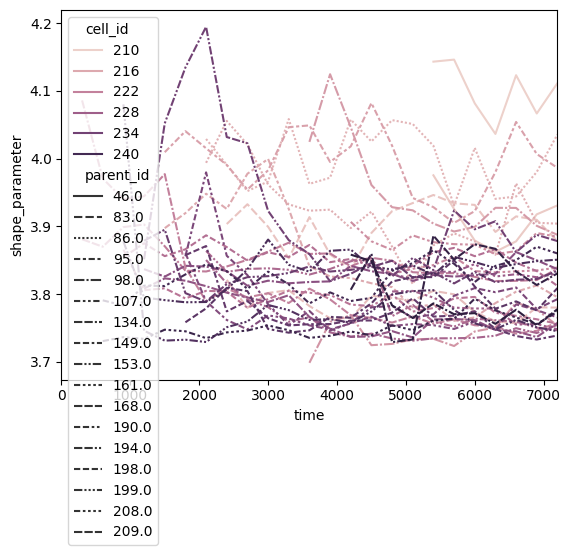

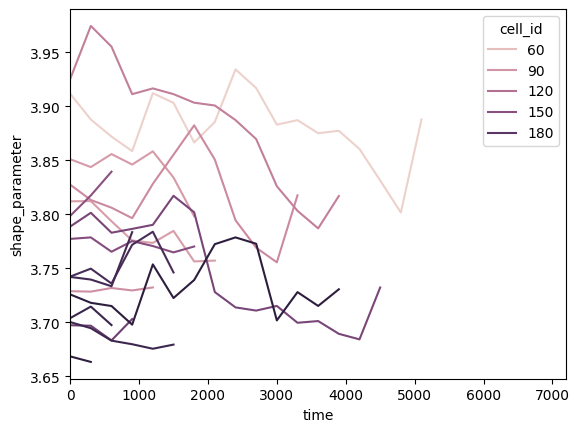

In [179]:
sns.lineplot(data=df_d[df_d.cell_id >=210], y='shape_parameter', x='time', hue='cell_id',style='parent_id')
plt.xlim(0, 7200)
plt.show()
sns.lineplot(data=df_d[df_d.cell_id <210], y='shape_parameter', x='time', hue='cell_id')
plt.xlim(0, 7200)
plt.show()

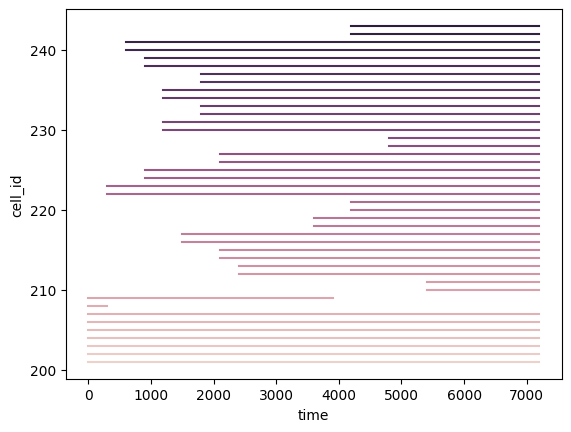

In [172]:
sns.lineplot(data=df_total[(df_total.cell_id>200)&(df_total.cell_id<260)], y='cell_id', x='time', hue='cell_id', legend=False)
plt.show()


In [169]:
np.unique(d_cells[:,0])
#d_cells[13]

array([ 46,  83,  86,  95,  98, 107, 134, 149, 153, 161, 168, 190, 194,
       198, 199, 208, 209])

In [139]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax11 = ax1.twinx()
sns.lineplot(data=df_total, x="time", y="area_norm", err_style='bars', errorbar='ci', ax=ax1, c='red')
sns.lineplot(data=df_total, x="time", y="perimeter_norm", err_style='bars', errorbar='ci', ax=ax11, c='blue')
ax1.tick_params(axis='y', colors='red')
ax11.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.99,1.15)
ax11.set_ylim(0.99,1.15)
ax11.set(ylabel="Mean Perimeter/Initial Perimeter")
ax1.set(ylabel="Mean Area/Initial Area")
ax1.yaxis.label.set_color('red')
ax11.yaxis.label.set_color('blue')


sns.lineplot(data=df, x="time", y="circularity", err_style='bars', errorbar='ci',ax=ax2)
sns.lineplot(data=df, x="time", y="shear_strain", err_style='bars', errorbar='ci', ax=ax3)
ax2.set_xlabel("time, s")
ax2.set_ylabel("mean circularity")
ax3.set_xlabel("time, s")
ax3.set_ylabel("mean shear strain")



fig.suptitle(" ")


plt.savefig(plot_dir+'/shape_line_all.png', dpi=300, bbox_inches='tight')

,cell_id,cell_perimeter_microns,cell_area_microns,cell_perimeter_nd,cell_area_nd,cell_P_eff_nd,shape_parameter,circularity,cell_edge_count,cell_shear,cell_zeta,major_shape_axis_alignment_rads,major_stress_axis_alignment_rads,frame,time,angle_horizontal
236,134.0,99.019462,688.07048,2.391787,0.401455,0.241169,3.774888,0.688905,6.0,0.0856,0.05097,2.576116,2.576116,1.0,0.0,0.565477


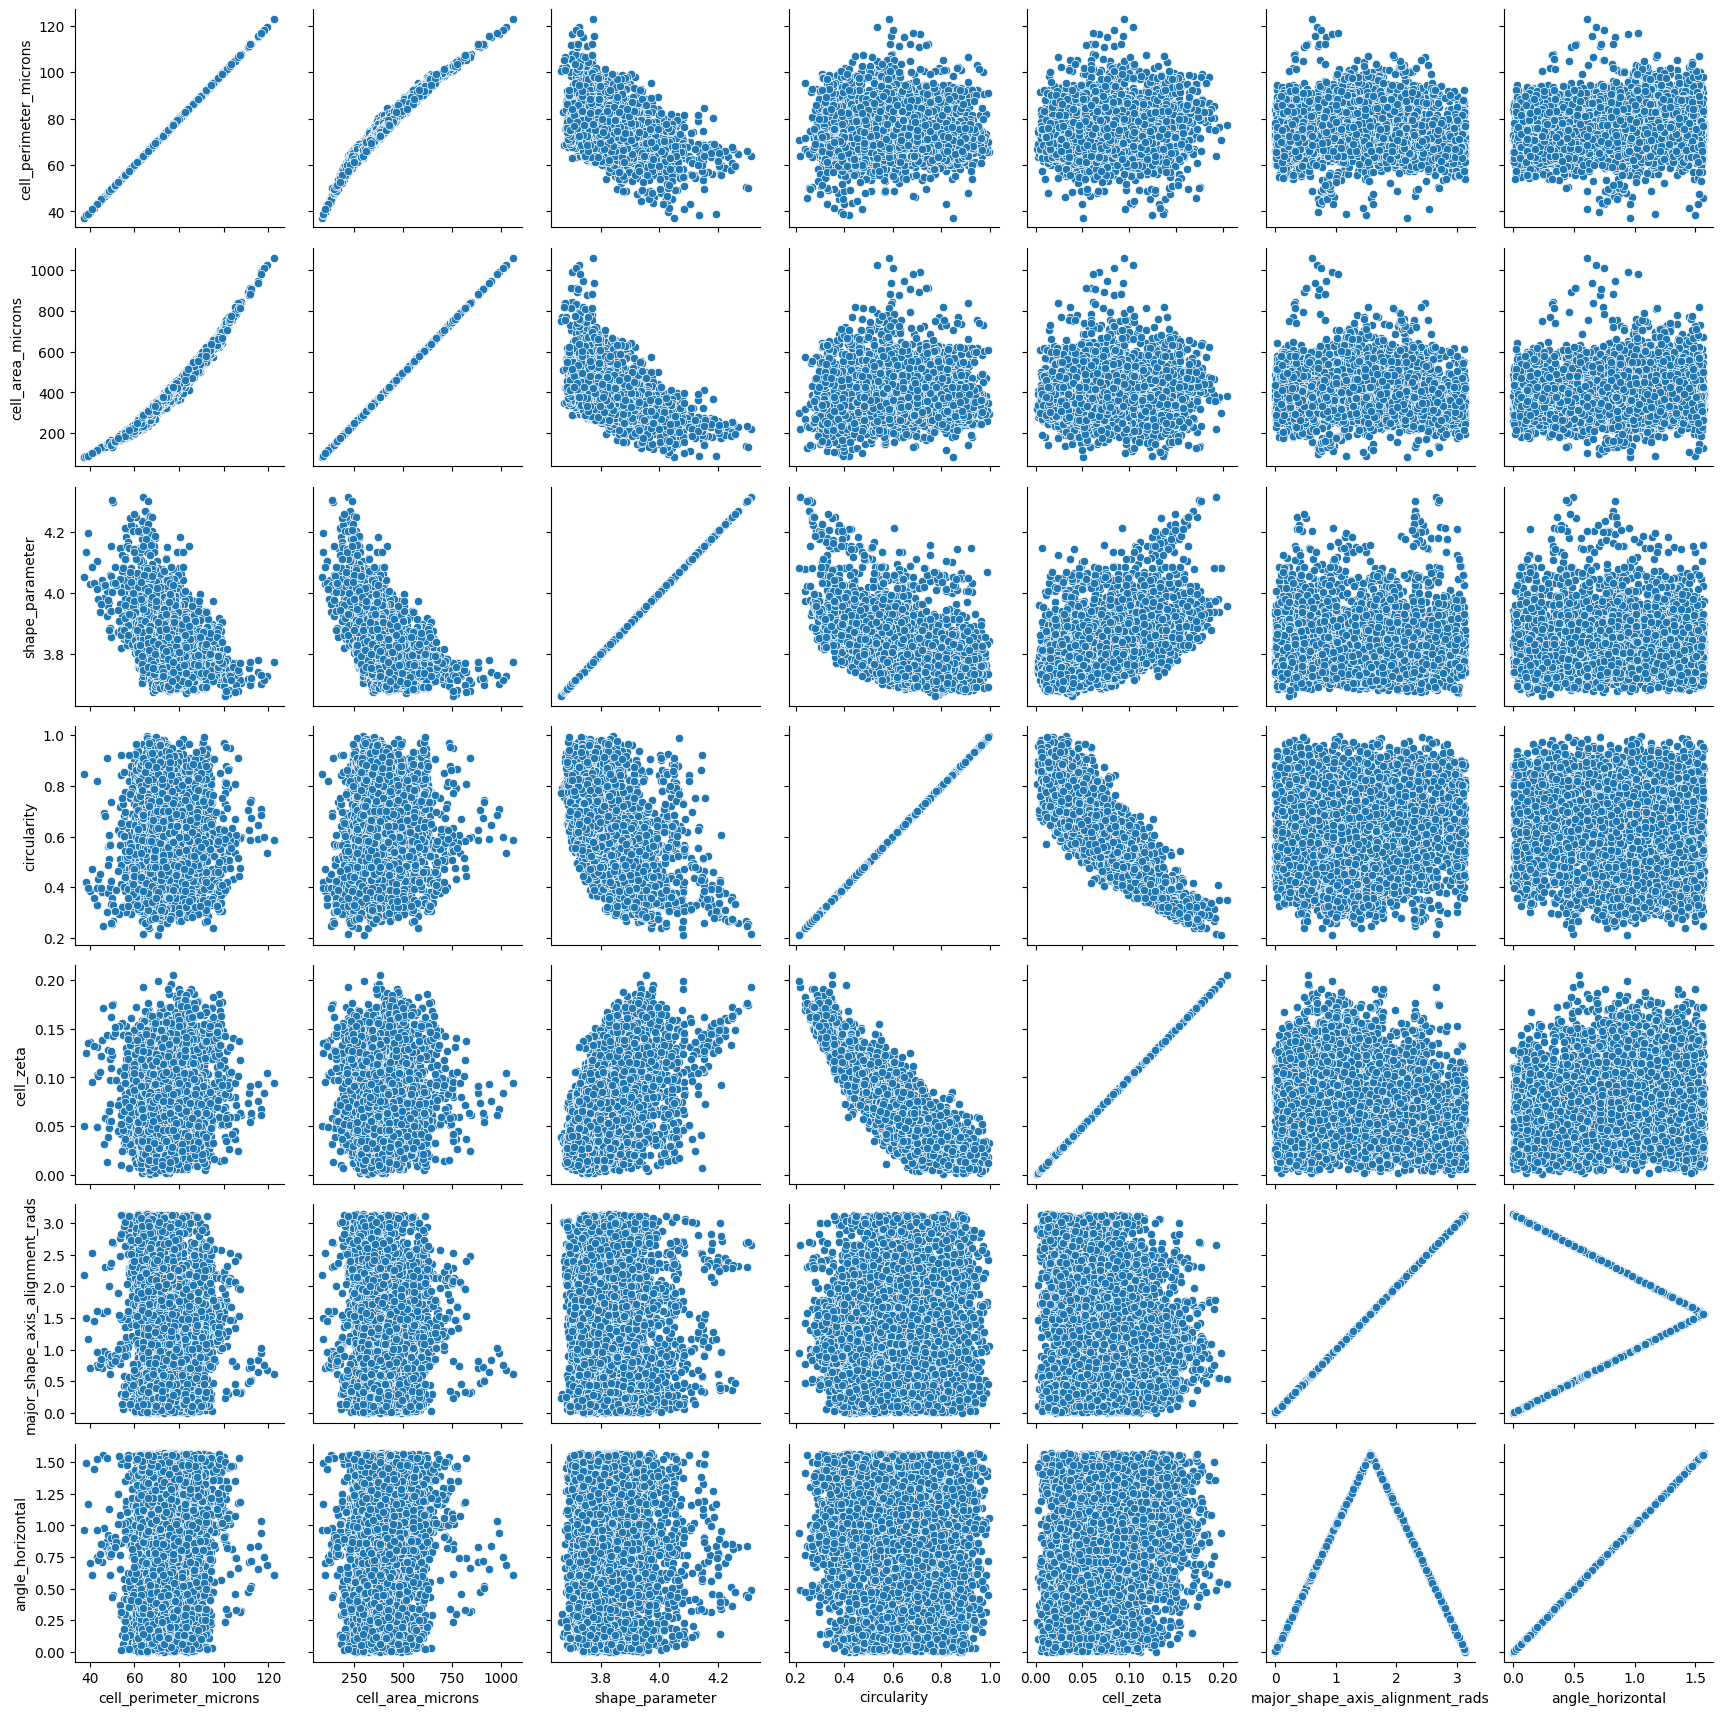

In [173]:
df_pp=df_dat[[ 'cell_perimeter_microns', 'cell_area_microns', 'shape_parameter',
       'circularity',  'cell_zeta',
       'major_shape_axis_alignment_rads', 'angle_horizontal']]
g = sns.PairGrid(df_pp)
g.map(sns.scatterplot)

In [ ]:
df_pp=df_dat[df_[[ 'cell_perimeter_microns', 'cell_area_microns', 'shape_parameter',
       'circularity',  'cell_zeta',
       'major_shape_axis_alignment_rads', 'angle_horizontal']]
g = sns.PairGrid(df_pp)
g.map(sns.scatterplot)

In [181]:
df_dat.size

88784

In [182]:
df_total.size

88720

In [187]:
df_nd.size+df_d.size

89440

In [186]:
df_d.size

12240